In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robbiesmith11","key":"bca9f2f67f6cc638d614364c9c732a10"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d polavr/twoclass-weather-classification

 95% 102M/107M [00:00<00:00, 226MB/s] 
100% 107M/107M [00:00<00:00, 228MB/s]


In [5]:
!unzip -q twoclass-weather-classification.zip -d . 

In [6]:
import numpy as np
import pandas as pd
from fastai.vision.all import*
from fastai.metrics import error_rate,accuracy


In [7]:
size = 224   # size of image 
bs = 25      # batch size 
np.random.seed(42)

In [8]:
path_anno = "/content/test"
path_img = "/content/train"     # store path to the images

In [9]:
import os 
labels = os.listdir(path_img)
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
  print("{}, {} files".format(label, len(os.listdir(path_img+"/"+label))))    # printts the number of files for each set

No. of labels: 2
-----------------
cloudy, 5000 files
sunny, 5000 files


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from fastai.vision.data import ImageDataLoaders

In [12]:
batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)] #normalises data to similar values so they can be compared, uses imagenets 14million size 

In [13]:
dls = ImageDataLoaders.from_folder(path_img,
                                    valid_pct=0.2,
                                    ds_tfms=batch_tfms,
                                    item_tfms=Resize(460),
                                    bs=bs)

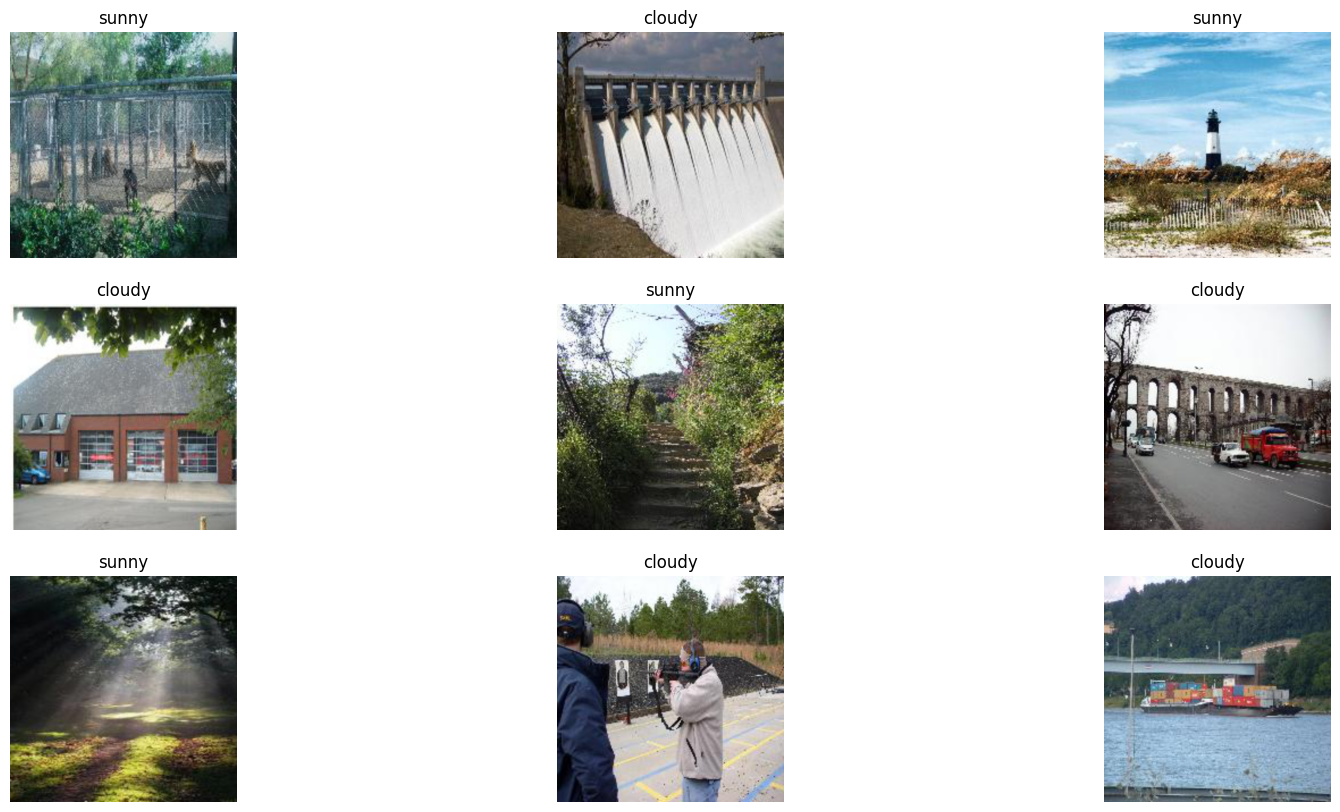

In [14]:
dls.show_batch(max_n=9, figsize=(20,10))

In [15]:
from fastai.callback.fp16 import *
from fastai.optimizer import RMSProp
#learn_res = vision_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16() # learner for resnet
learn_eff = vision_learner(dls, efficientnet_b2, metrics=[accuracy, error_rate], opt_func=RMSProp).to_fp16() # learner for efficientnet
#learn_dense = vision_learner(dls, densenet121, metrics=[accuracy, error_rate]).to_fp16() # learner for densenet

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 99.6MB/s]


In [16]:
learn_eff.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sigm

In [ ]:
#learn_res.fit_one_cycle(4)       # trains each model for 4 epochs
#learn_dense.fit_one_cycle(4)
learn_eff.fit_one_cycle(4)


epoch,train_loss,valid_loss,accuracy,error_rate,time


In [ ]:
#lr_min, lr_steep = learn_res.lr_find(suggest_funcs=(minimum, steep))
#lr_min, lr_steep = learn_dense.lr_find(suggest_funcs=(minimum, steep))
lr_min, lr_steep = learn_eff.lr_find(suggest_funcs=(minimum, steep))



In [ ]:
print(f"Mininum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}") # can gather the best learning rate by slciing the two points

In [ ]:
#learn_dense.unfreeze()
#learn_dense.fit_one_cycle(2, lr_max=slice(10**-5.5,10**-4.5))

#learn_res.unfreeze()
##learn_res.fit_one_cycle(2, lr_max=slice(10**-6,10**-5.5))

learn_eff.unfreeze()
learn_eff.fit_one_cycle(2, lr_max=slice(10**-6,10**-5.5))

In [ ]:
#interpret = ClassificationInterpretation.from_learner(learn_res)
#interpret = ClassificationInterpretation.from_learner(learn_dense)
interpret = ClassificationInterpretation.from_learner(learn_eff)

In [ ]:
interpret.plot_confusion_matrix(figsize=(6,6), dpi=60)   #plots the confusion matrix for the model
